In [ ]:
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

In [ ]:
start_date = dt.datetime.now() - dt.timedelta(days=365 * 50)
end_date = dt.datetime.now()

df = yf.download("AMAT", start=start_date, end=end_date)

df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['50_day_ma'] = df['Close'].rolling(window=50).mean()
df['1000_day_ma'] = df['Close'].rolling(window=1000).mean()
df['10_day_vol_avg'] = df['Volume'].rolling(window=10).mean()
df['200_day_vol_avg'] = df['Volume'].rolling(window=200).mean()

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']]

df.to_csv('AMAToutput.csv', index=False)

print(df)

[*********************100%%**********************]  1 of 1 completed
            Date        Open        High         Low       Close   Volume  \
0     1980-03-17    0.000000    0.098090    0.095486    0.095486  3600000   
1     1980-03-18    0.000000    0.096354    0.093750    0.093750  3715200   
2     1980-03-19    0.000000    0.098090    0.095486    0.095486  2016000   
3     1980-03-20    0.000000    0.099826    0.097222    0.097222  3657600   
4     1980-03-21    0.000000    0.103299    0.100694    0.100694  3024000   
...          ...         ...         ...         ...         ...      ...   
10942 2023-08-10  146.770004  147.979996  143.100006  144.610001  4018300   
10943 2023-08-11  142.220001  142.470001  138.529999  138.830002  5189900   
10944 2023-08-14  138.199997  141.940002  137.669998  141.889999  4850400   
10945 2023-08-15  141.270004  141.850006  139.740005  140.080002  3384900   
10946 2023-08-16  140.529999  141.259995  138.169998  138.250000  4611500   

      

In [ ]:
dfm = df.loc[1000:,:]
dfm = dfm.sample(100)

In [ ]:
corr = dfm.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

<ipython-input-39-4f967d6aa235>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dfm.corr()


,Open,High,Low,Close,Volume,50_day_ma,1000_day_ma,10_day_vol_avg,200_day_vol_avg
Open,1.00,1.00,1.00,1.00,-0.25,0.99,0.94,-0.30,-0.33
High,1.00,1.00,1.00,1.00,-0.25,0.99,0.94,-0.29,-0.33
Low,1.00,1.00,1.00,1.00,-0.25,0.99,0.94,-0.30,-0.33
Close,1.00,1.00,1.00,1.00,-0.25,0.99,0.94,-0.29,-0.33
Volume,-0.25,-0.25,-0.25,-0.25,1.00,-0.25,-0.23,0.81,0.74
50_day_ma,0.99,0.99,0.99,0.99,-0.25,1.00,0.94,-0.30,-0.33
1000_day_ma,0.94,0.94,0.94,0.94,-0.23,0.94,1.00,-0.29,-0.31
10_day_vol_avg,-0.30,-0.29,-0.30,-0.29,0.81,-0.30,-0.29,1.00,0.88
200_day_vol_avg,-0.33,-0.33,-0.33,-0.33,0.74,-0.33,-0.31,0.88,1.00


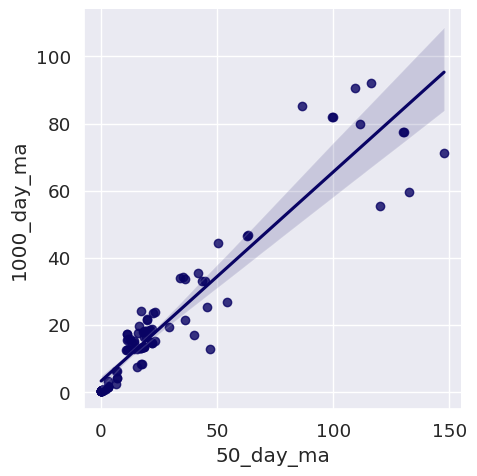

In [ ]:
sns.lmplot(data=dfm, x='50_day_ma', y='1000_day_ma')

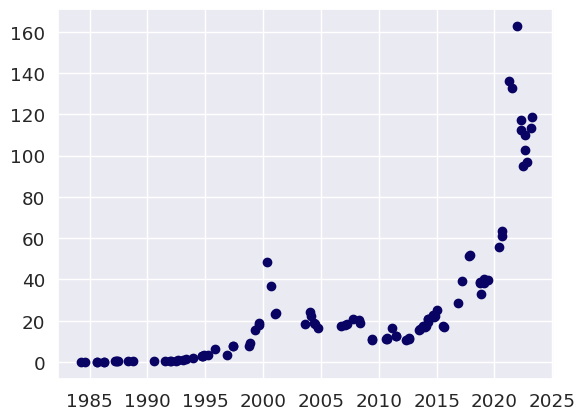

In [ ]:
plt.plot_date(dfm['Date'], dfm['Open'])

In [ ]:
df.set_index('Date', inplace=True)

df.dropna(inplace=True)

df = df.drop(df.index[0:2000])

train_df = df.sort_values(by=['Date']).copy()

#FEATURES = ['Close', '50_day_ma', '200_day_ma']
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']

print('FEATURE LIST')
print([f for f in FEATURES])

print(df)

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume', '50_day_ma', '1000_day_ma', '10_day_vol_avg', '200_day_vol_avg']
                  Open        High         Low       Close    Volume  \
Date                                                                   
1992-01-27    0.593750    0.597656    0.582031    0.589844   6912000   
1992-01-28    0.597656    0.605469    0.593750    0.597656  10969600   
1992-01-29    0.593750    0.628906    0.593750    0.609375  17113600   
1992-01-30    0.609375    0.625000    0.582031    0.597656  16531200   
1992-01-31    0.597656    0.607422    0.593750    0.599609   4000000   
...                ...         ...         ...         ...       ...   
2023-08-10  146.770004  147.979996  143.100006  144.610001   4018300   
2023-08-11  142.220001  142.470001  138.529999  138.830002   5189900   
2023-08-14  138.199997  141.940002  137.669998  141.889999   4850400   
2023-08-15  141.270004  141.850006  139.740005  140.080002   3384900   
2023-08-16  140

<ipython-input-42-2b700938e4a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
sequence_length = 200

index_Close = data_filtered.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [ ]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(index_Close)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

3
3
(6954, 200, 9) (6954,)
(794, 200, 9) (794,)
0.0030037077102985765
0.0030037077102985765
1800 200 9


In [ ]:
model.compile(optimizer='adam', loss='mse')

epochs = 30
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience = 3, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/30
435/435 [==============================] - 202s 449ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/30
435/435 [==============================] - 214s 492ms/step - loss: 7.7328e-05 - val_loss: 8.6852e-04
Epoch 3/30
435/435 [==============================] - 215s 493ms/step - loss: 5.3668e-05 - val_loss: 0.0013
Epoch 4/30
435/435 [==============================] - 213s 491ms/step - loss: 5.0758e-05 - val_loss: 5.9738e-04
Epoch 5/30
435/435 [==============================] - 214s 492ms/step - loss: 4.2338e-05 - val_loss: 0.0013
Epoch 6/30
435/435 [==============================] - 214s 492ms/step - loss: 3.6108e-05 - val_loss: 0.0038
Epoch 7/30
435/435 [==============================] - 214s 492ms/step - loss: 3.2806e-05 - val_loss: 5.9693e-04
Epoch 8/30
435/435 [==============================] - 214s 493ms/step - loss: 3.3072e-05 - val_loss: 3.9528e-04
Epoch 9/30
435/435 [==============================] - 214s 492ms/step - loss: 3.4548e-05 - val_loss: 4.1749e-04
Epoch 10/30


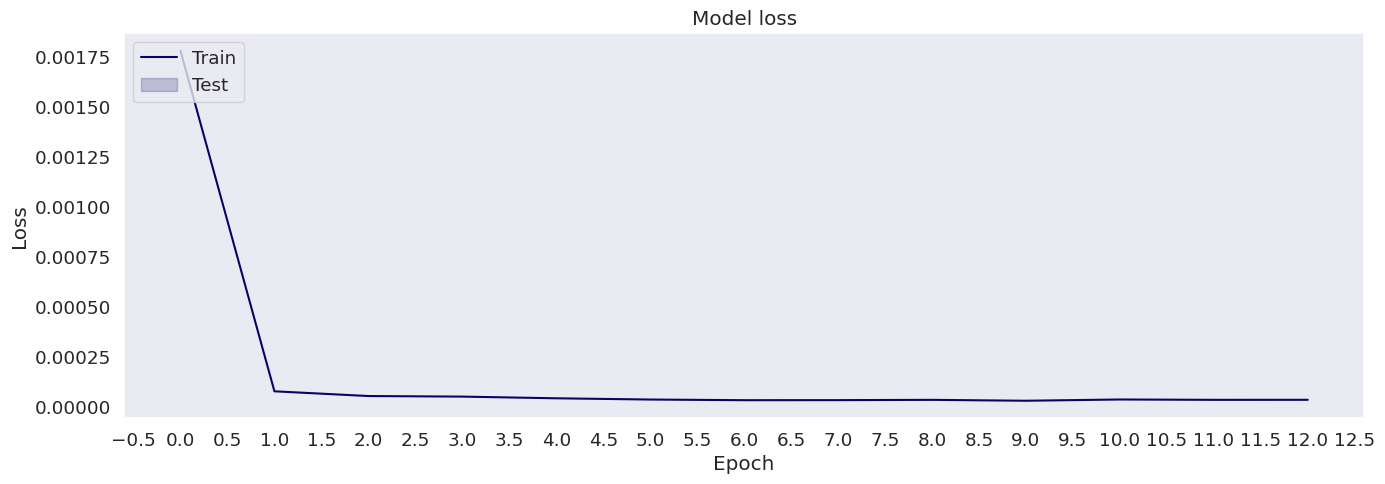

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

25/25 [==============================] - 7s 241ms/step
Accuracy: 0.458 %
Precision: 0.472 %
Recall: 0.477 %
F Score: 0.474 %


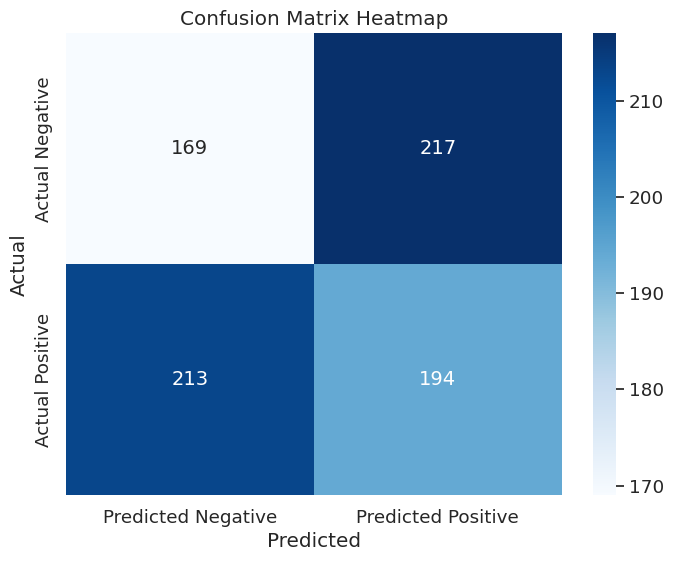

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

y_pred_bin = []
y_test_bin = []

for i in range(1, len(y_pred)):
    if (y_pred[i] > y_pred[i-1]):
      y_pred_bin.append(1)
    else:
      y_pred_bin.append(-1)

for i in range(1, len(y_test_unscaled)):
    if (y_test_unscaled[i] > y_test_unscaled[i-1]):
      y_test_bin.append(1)
    else:
      y_test_bin.append(-1)

count_up = 0
count_down = 0
total_up = 0
total_down = 0
for i in range(len(y_pred_bin)):
  if (y_pred_bin[i] == y_test_bin[i]):
    if (y_pred_bin[i] == 1):
      count_up += 1
    else:
      count_down += 1
  if (y_test_bin[i] == 1):
    total_up += 1
  else:
    total_down += 1

accuracy = (count_up + count_down)/(total_up + total_down)
precision = count_up/(count_up + total_down - count_down)
recall = count_up/(total_up)
f_score = 2 * (precision*recall)/(precision + recall)

print(f'Accuracy: {np.round(accuracy, 3)} %')
print(f'Precision: {np.round(precision, 3)} %')
print(f'Recall: {np.round(recall, 3)} %')
print(f'F Score: {np.round(f_score, 3)} %')

cm = confusion_matrix(y_test_bin, y_pred_bin)

# Create a heatmap of the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14}, cbar=True,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

DatetimeIndex(['1992-01-27', '1992-01-28', '1992-01-29', '1992-01-30',
               '1992-01-31', '1992-02-03', '1992-02-04', '1992-02-05',
               '1992-02-06', '1992-02-07',
               ...
               '2023-08-03', '2023-08-04', '2023-08-07', '2023-08-08',
               '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-14',
               '2023-08-15', '2023-08-16'],
              dtype='datetime64[ns]', name='Date', length=7949, freq=None)


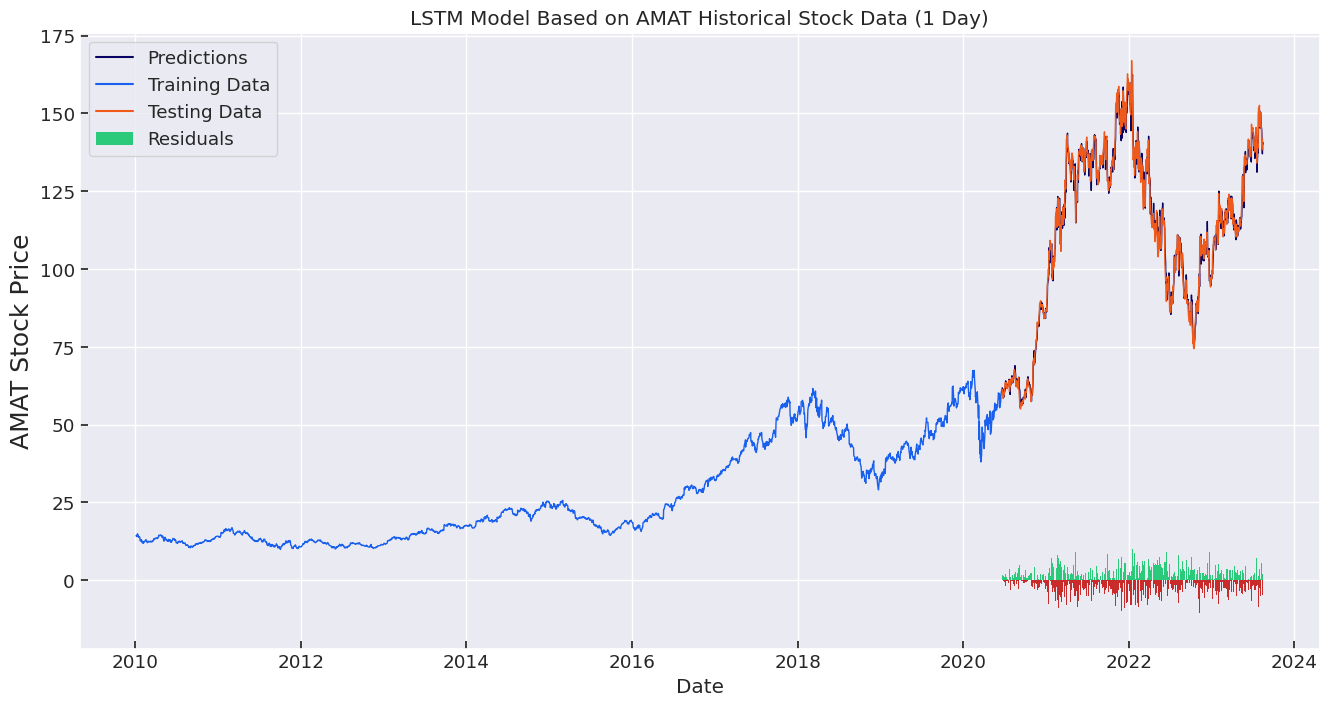

In [ ]:
display_start_date = "2010-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'Testing Data'})
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Day)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

DatetimeIndex(['1992-01-27', '1992-01-28', '1992-01-29', '1992-01-30',
               '1992-01-31', '1992-02-03', '1992-02-04', '1992-02-05',
               '1992-02-06', '1992-02-07',
               ...
               '2023-08-03', '2023-08-04', '2023-08-07', '2023-08-08',
               '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-14',
               '2023-08-15', '2023-08-16'],
              dtype='datetime64[ns]', name='Date', length=7949, freq=None)


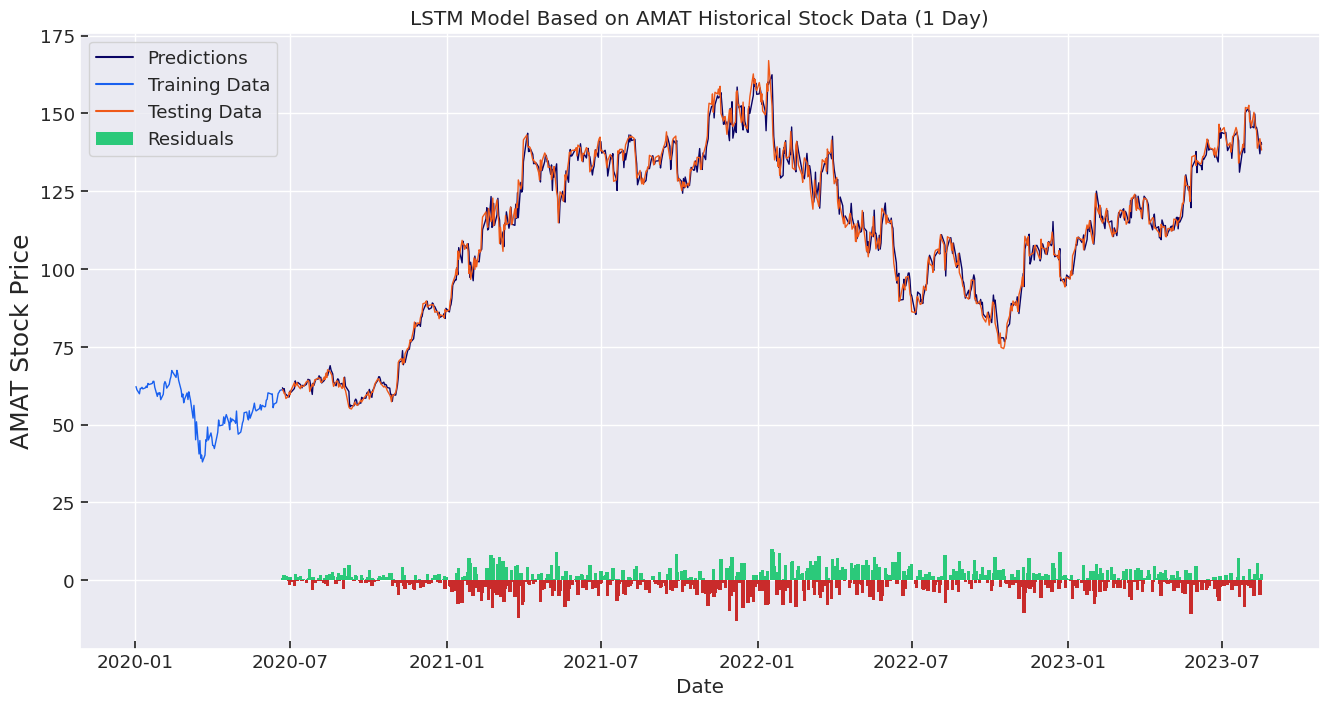

In [ ]:
display_start_date = "2020-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'Testing Data'})
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Day)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

DatetimeIndex(['1992-01-27', '1992-01-28', '1992-01-29', '1992-01-30',
               '1992-01-31', '1992-02-03', '1992-02-04', '1992-02-05',
               '1992-02-06', '1992-02-07',
               ...
               '2023-08-03', '2023-08-04', '2023-08-07', '2023-08-08',
               '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-14',
               '2023-08-15', '2023-08-16'],
              dtype='datetime64[ns]', name='Date', length=7949, freq=None)


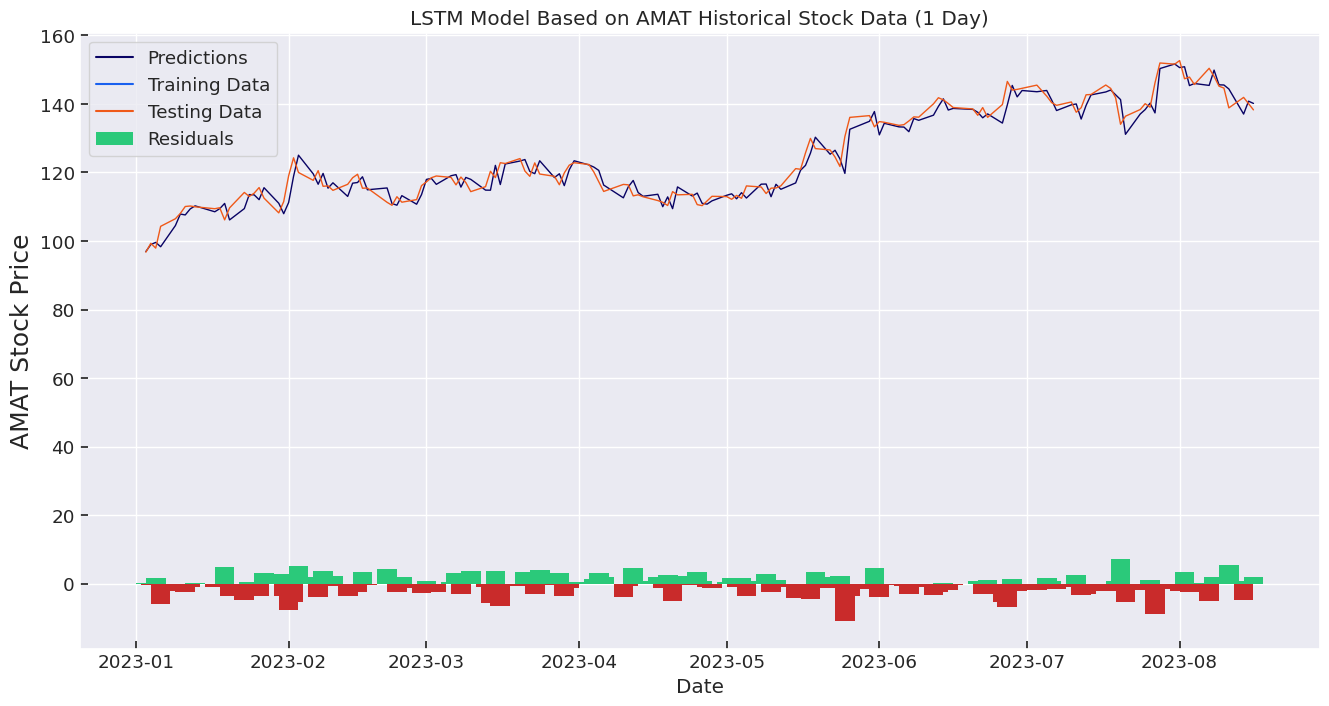

In [ ]:
display_start_date = "2023-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'Testing Data'})
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Day)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''

print(f'The close price for {"AMAT"} at {str(dt.date.today())} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


1/1 [==============================] - 0s 27ms/step
The close price for AMAT at 2023-08-17 was 138.25
The predicted close price is 138.3699951171875 (+0.09%)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform predictions
train_predict = scaler_pred.inverse_transform(train_predict)
y_train = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler_pred.inverse_transform(test_predict)
y_test = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mae_train = mean_absolute_error(y_train, train_predict)
mse_train = mean_squared_error(y_train, train_predict)
rmse_train = np.sqrt(mse_train)

mae_test = mean_absolute_error(y_test, test_predict)
mse_test = mean_squared_error(y_test, test_predict)
rmse_test = np.sqrt(mse_test)

print(f'Training MAE: {mae_train:.4f}')
print(f'Training MSE: {mse_train:.4f}')
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Testing MAE: {mae_test:.4f}')
print(f'Testing MSE: {mse_test:.4f}')
print(f'Testing RMSE: {rmse_test:.4f}')

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(y_test, test_predict)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

r2 = r2_score(y_test, test_predict)
print(f"R-squared (R2): {r2:.4f}")

3
3
25/25 [==============================] - 6s 231ms/step
Training MAE: 0.4520
Training MSE: 0.5684
Training RMSE: 0.7539
Testing MAE: 2.5347
Testing MSE: 11.1351
Testing RMSE: 3.3369
Mean Absolute Percentage Error: 2.2503
R-squared (R2): 0.9849
